In [174]:
import datetime
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.stats.power import tt_ind_solve_power
from sklearn.preprocessing import LabelEncoder
from pandas._libs.tslibs.timestamps import Timestamp
from statsmodels.stats.power import tt_ind_solve_power
from tqdm.notebook import tqdm

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [3]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 123

### Задание 3
**Срок сдачи: 04 апреля 21:00**

**Финальный срок сдачи с понижением балов до 50%: 09 апреля 21:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 бала). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 бала).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - тип продукта

region - регион

category - категория авито

revenue_amount - сумма покупок


In [2]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date'] = df.event_date.apply(date_converter)

## EDA

Смотрим на данные и их размер

In [5]:
print(df.shape)
df.head()

(4096929, 6)


,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4.626945e+18,7.204754e+18,2.201389e+18,139.0
1,2019-06-18,7225254357470025,4.626945e+18,5.751401e+16,3.048518e+18,193.0
2,2019-06-18,8912846500600569,4.626945e+18,5.983324e+18,3.048518e+18,160.0
3,2019-06-18,20910801279823046,4.626945e+18,6.847326e+18,7.762196e+18,209.0
4,2019-06-18,34873300821657220,2.376074e+18,3.187770e+18,3.855811e+18,160.0


Преобразуем `user_segment, category, region` с помощью `LabelEncoder` из sklearn

In [38]:
user_segment_enc = LabelEncoder().fit(df.user_segment.values)
category_enc = LabelEncoder().fit(df.category.values)
region_enc = LabelEncoder().fit(df.region.values)

In [39]:
df['user_segment'] = user_segment_enc.transform(df.user_segment)
df['category'] = category_enc.transform(df.category)
df['region'] = region_enc.transform(df.region)

За какой временной промежуток предоставлены данные?

In [205]:
TOTAL_DAYS = (df.event_date.max().date() - df.event_date.min().date()).days + 1
print(f'{TOTAL_DAYS} days:', df.event_date.min().date(), '-', df.event_date.max().date())

101 days: 2019-06-18 - 2019-09-26


Визуализируем распределение пользователей по стратам  
<u> Замечание:</u> один юзер может входить в несколько страт, здесь единица измерения -- это транзакция

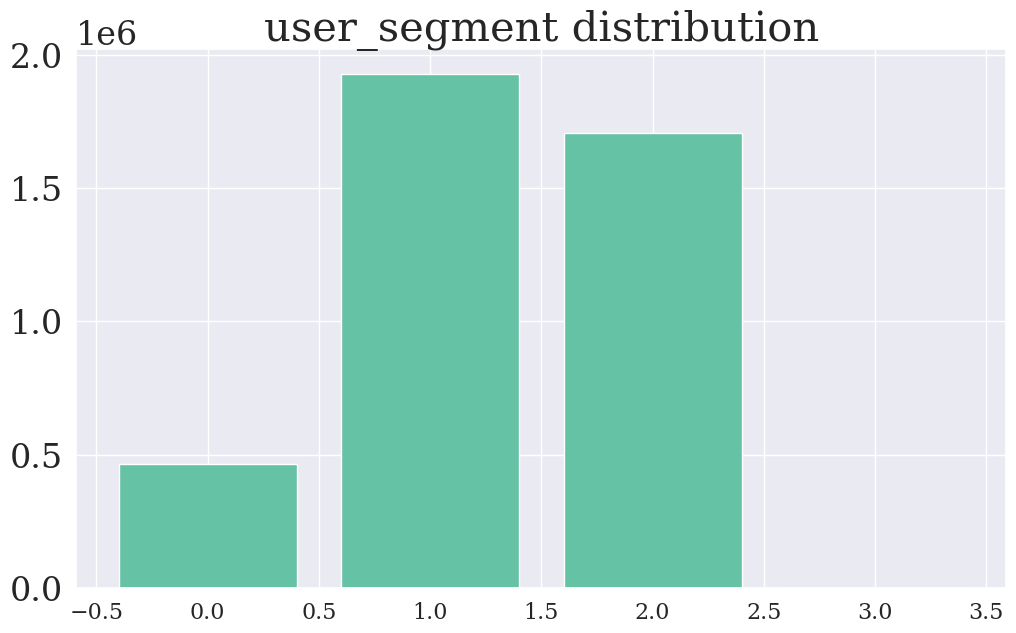

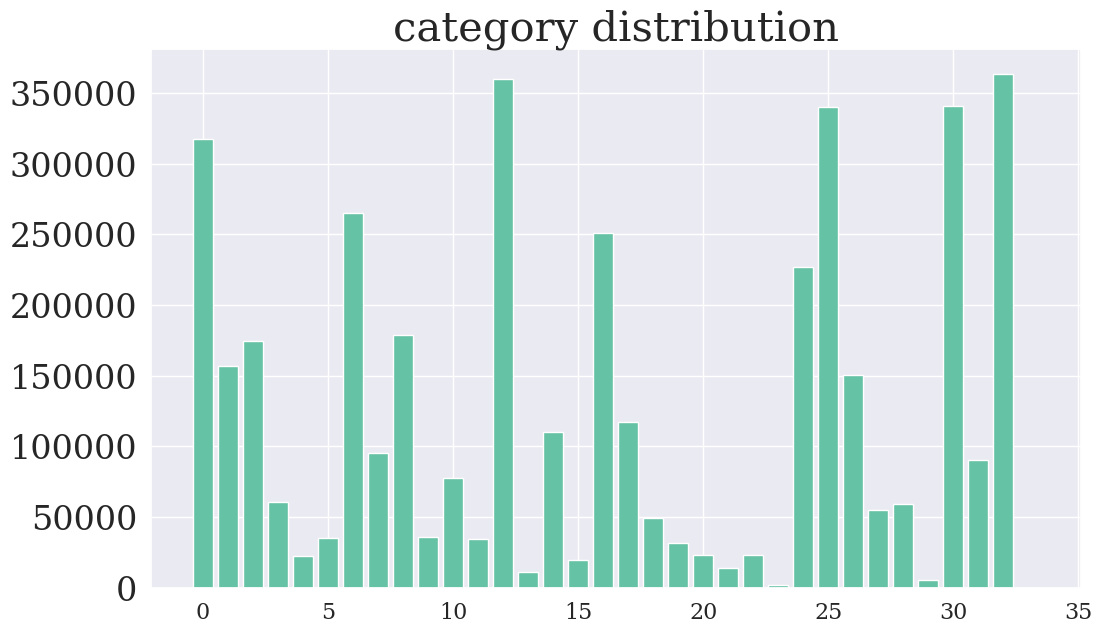

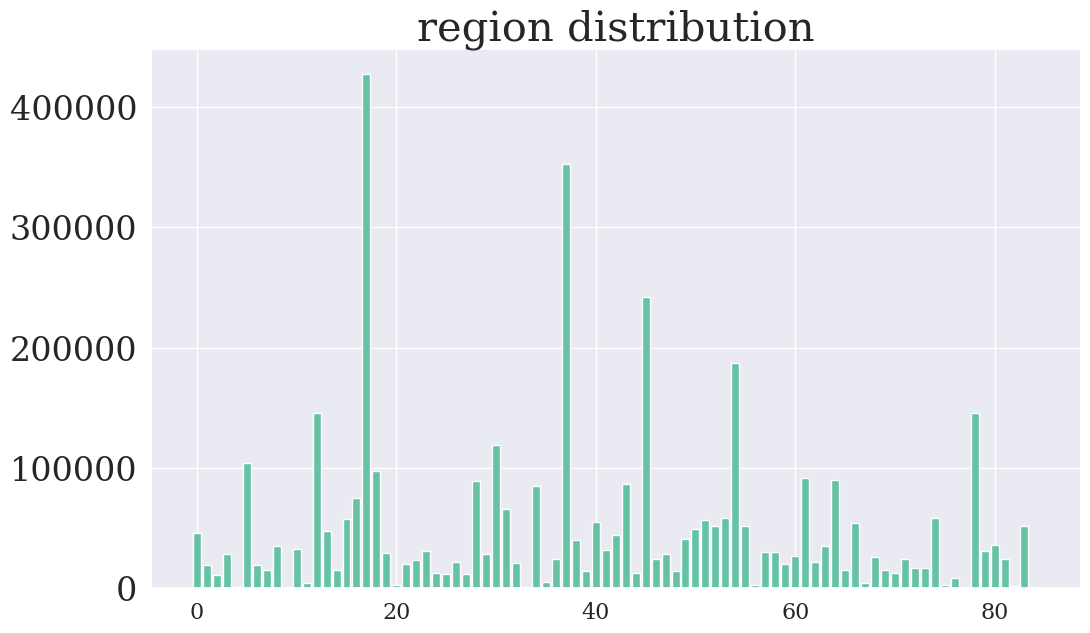

In [48]:
for col in ['user_segment', 'category', 'region']:
    col_counter = df[[col]].value_counts()
    xlabels = list(map(lambda x: x[0], col_counter.index.values))
    plt.bar(x=xlabels, height=col_counter)
    plt.title(f'{col} distribution')
    plt.show()

**Вывод:**  
Видим, что распределение транзакций по стратам неравномерно

Взглянем на целевую метрику

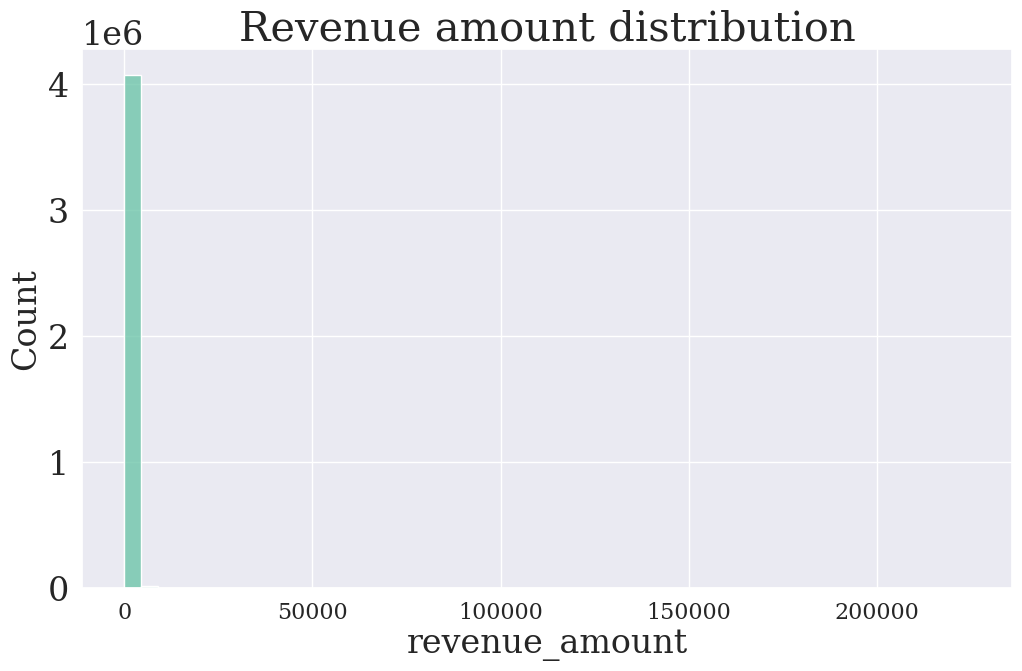

In [22]:
sns.histplot(df.revenue_amount, bins=50)
plt.title('Revenue amount distribution')
plt.show()

In [29]:
print(df.revenue_amount.describe(percentiles=[0.25, 0.75, 0.95, 0.99, 0.999]).apply(lambda x: round(x, 3)))

count    4096928.000
mean         409.816
std          938.836
min            4.000
25%           90.000
50%          176.000
75%          420.000
95%         1434.000
99%         3273.000
99.9%      10233.000
max       224587.000
Name: revenue_amount, dtype: float64


**Вывод:**  
Видим, что распределение выручки имеет выбросы

Взглянем на распределение выручки по стратам

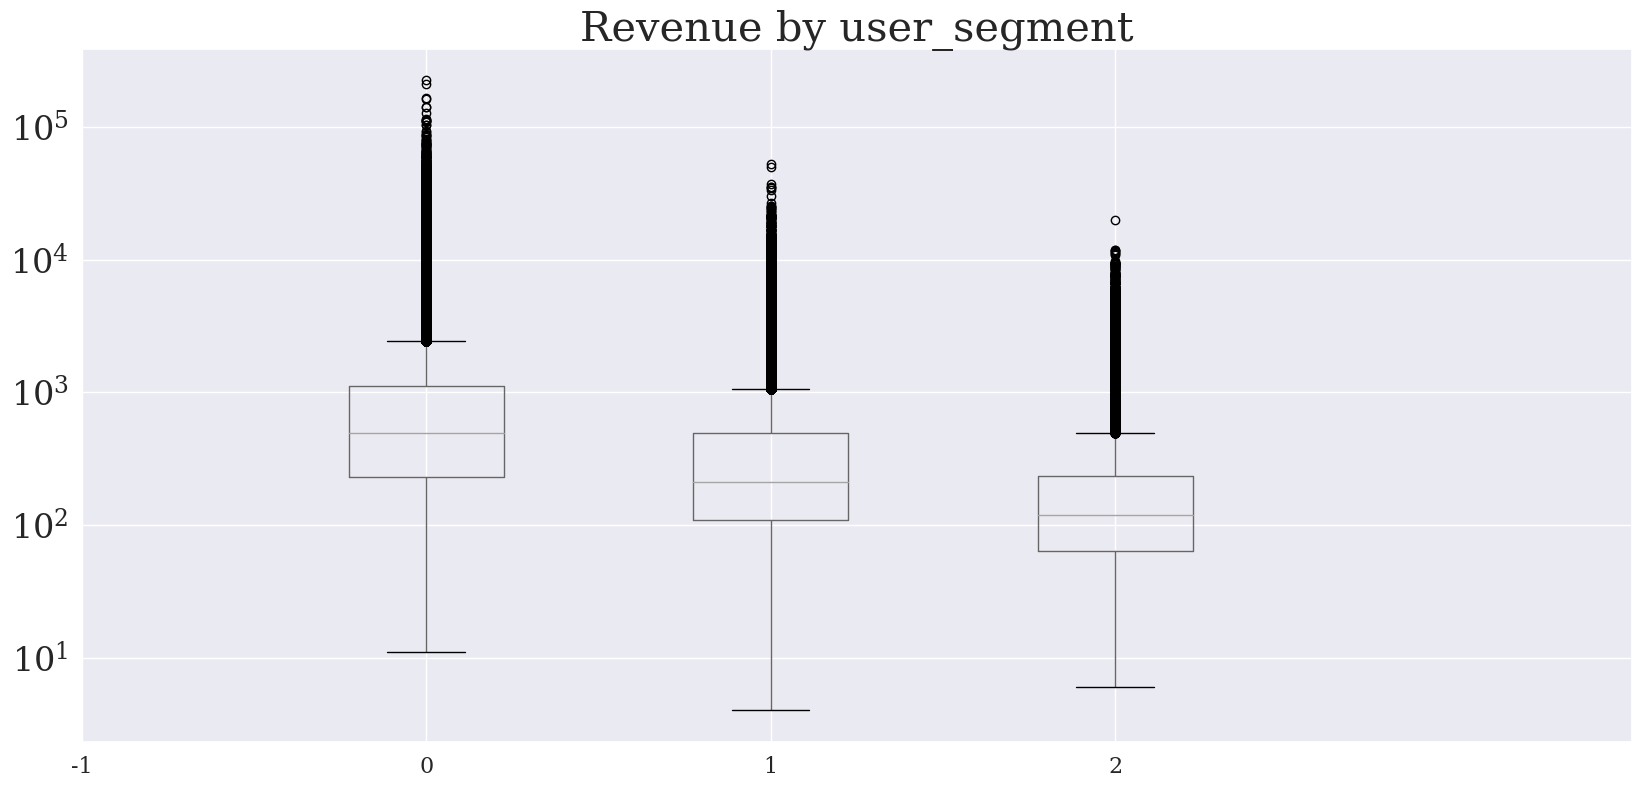

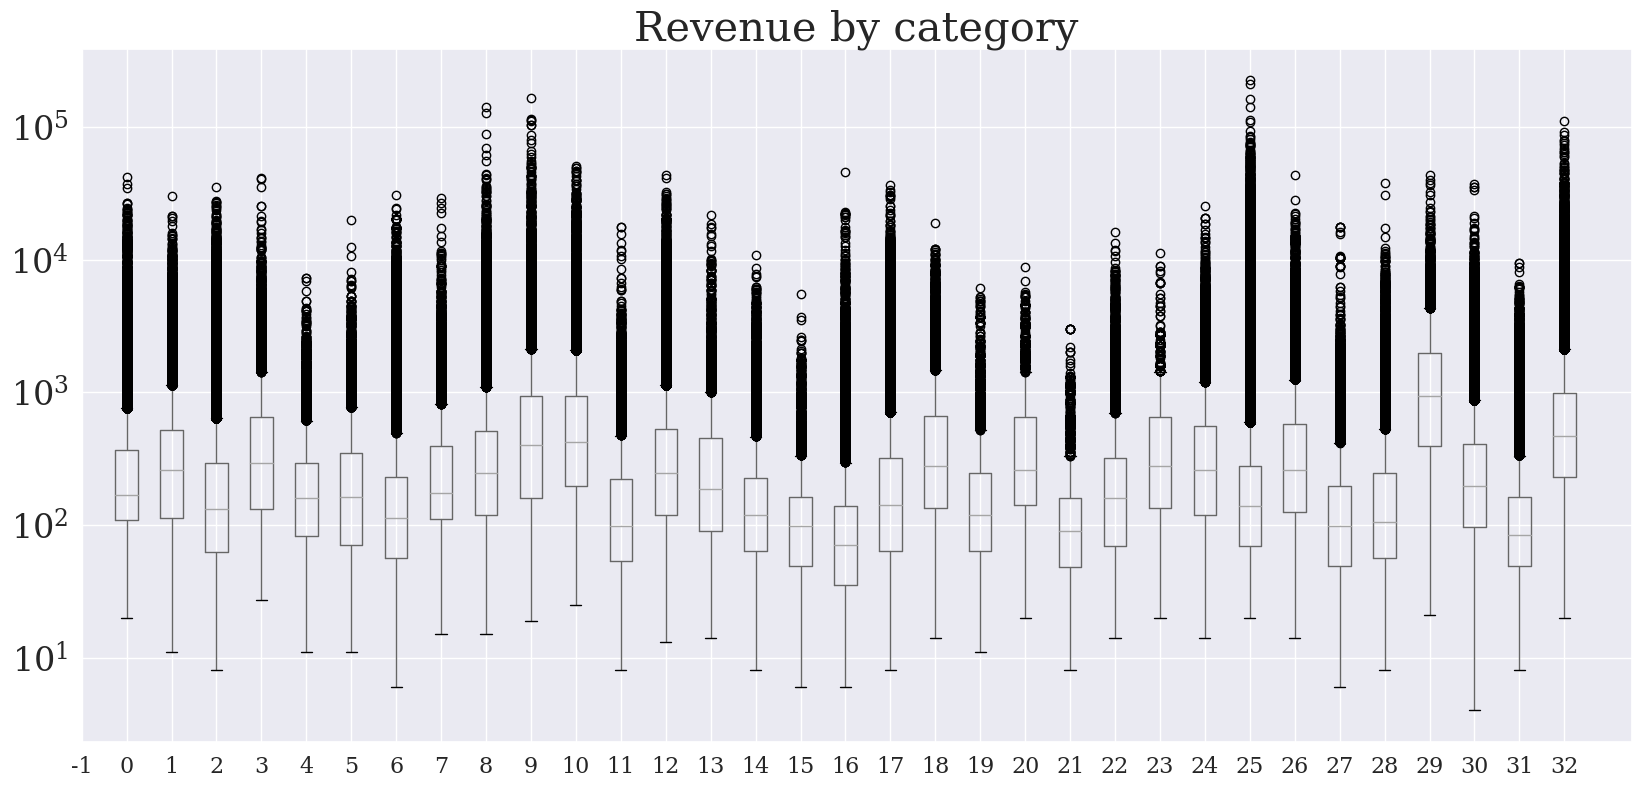

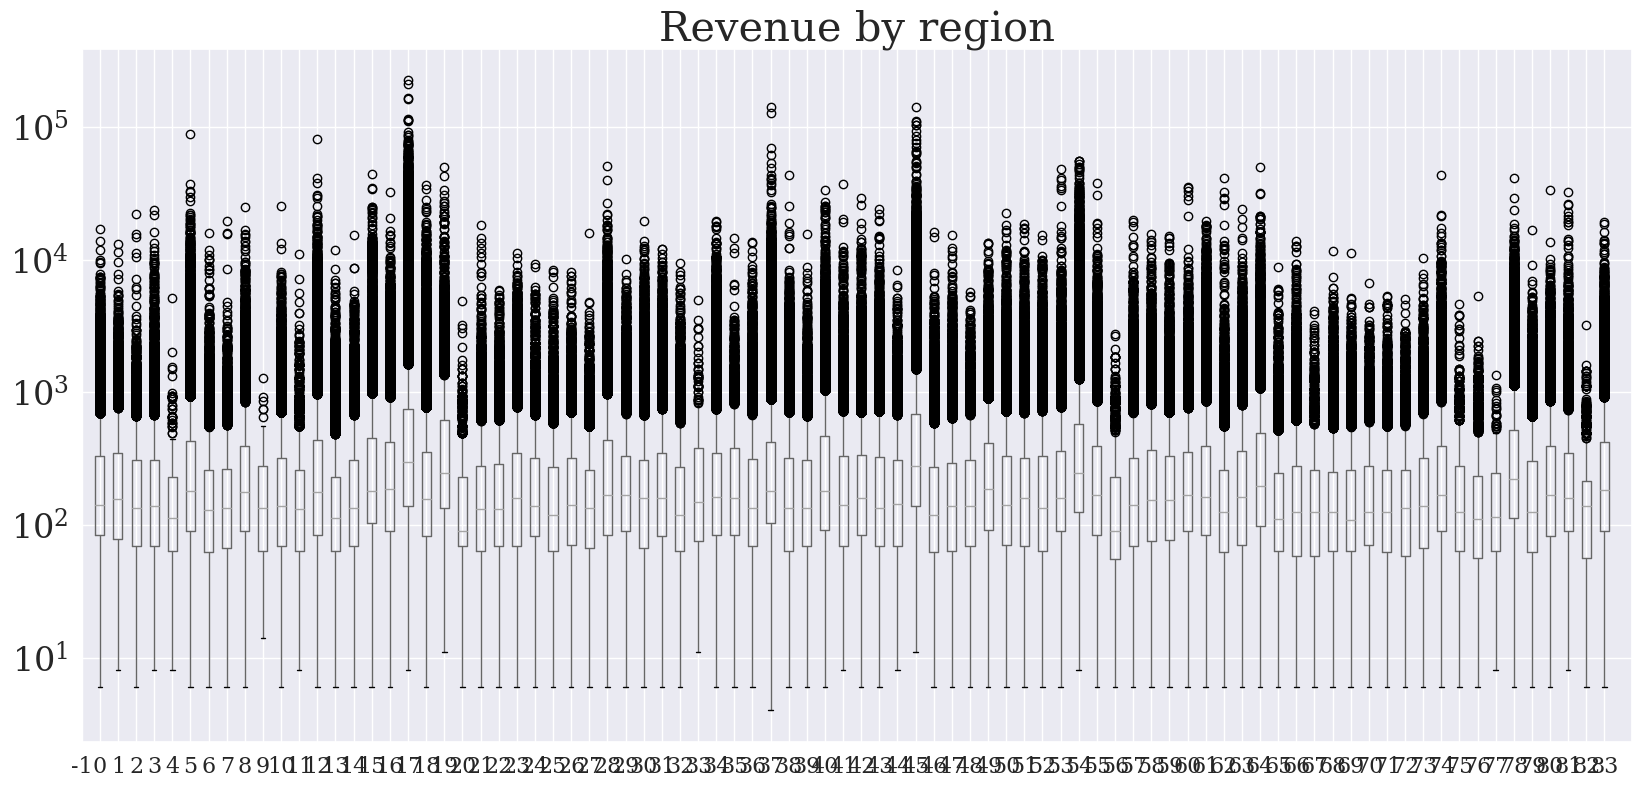

In [103]:
for col in ['user_segment', 'category', 'region']:
    grouped = df.groupby(col)[['revenue_amount']]
    plt.figure(figsize=(20, 9))
    ax = plt.gca()
    grouped.boxplot(subplots=False, ax=ax)
    plt.title(f'Revenue by {col}')
    plt.xticks(ticks=range(len(grouped)), labels=[str(x-1) for x in range(len(grouped))])
    plt.yscale('log')
    plt.show()

**Вывод:**  
Видим, что распределение транзакций по типу продукта и по категории авито рознится, в то время как по регионам эта неравномерность выражена слабее

## Подсчёт MDE

In [148]:
def choose_date(data: pd.DataFrame, start_date: Timestamp, delta: int, share: float, to_shift: bool = False) -> pd.DataFrame: 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp = tmp.groupby(['user_id'])['revenue_amount'].sum().reset_index()
    
    if to_shift:
        x = tmp[(tmp.user_id-int(100*share))%100<int(100*share)].reset_index()
    else:
        x = tmp[(tmp.user_id)%100<int(100*share)].reset_index()
        
    return x

In [252]:
for days in (30, 60, 90):
    for ratio in (0.1, 0.25, 0.5):
        print(f'days = {days}, ratio = {ratio}')
        x1 = choose_date(df, df.event_date.min(), days, ratio)
        mean = x1.revenue_amount.mean()
        std = x1.revenue_amount.std()
        
        alpha = 0.01
        power = 0.75
        
        effect_size = tt_ind_solve_power(None, len(x1), alpha, power)
        result_effect = effect_size * std / mean
        
        print('k_observations =', len(x1))
        print(f'Result effect = {result_effect*100:.3f}%')
        print('='*80)

days = 30, ratio = 0.1
k_observations = 61742
Result effect = 11.179%
days = 30, ratio = 0.25
k_observations = 154558
Result effect = 9.146%
days = 30, ratio = 0.5
k_observations = 309149
Result effect = 5.661%
days = 60, ratio = 0.1
k_observations = 93724
Result effect = 10.852%
days = 60, ratio = 0.25
k_observations = 234389
Result effect = 8.895%
days = 60, ratio = 0.5
k_observations = 468967
Result effect = 5.522%
days = 90, ratio = 0.1
k_observations = 118738
Result effect = 10.869%
days = 90, ratio = 0.25
k_observations = 296947
Result effect = 8.874%
days = 90, ratio = 0.5
k_observations = 593999
Result effect = 5.529%


**Вывод:**  
Даже с максимальным набором данных MDE составляет 5.5%, что очень много.  
Далее, будем уменьшать MDE путём уменьшения дисперсии

## CUPED

Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней

In [190]:
days = 30
alpha = 0.01
power = 0.75


for ratio in (0.1, 0.25, 0.5):
    # pred_data.user_id % 100 ∈ [0, 2*int(100*ratio))
    # control_data.user_id % 100 ∈ [0, int(100*ratio))
    # test_data.user_id % 100 ∈ [int(100*ratio), 2*int(100*ratio)) because to_shift == True
    
    print(f'days = {days}, ratio = {ratio}')
    
    # Collect data
    pred_data = choose_date(df, df.event_date.min(), days, 2*ratio)
    control_data = choose_date(df, df.event_date.min() + pd.to_timedelta(days, 'days'), days, ratio)
    test_data = choose_date(df, df.event_date.min() + pd.to_timedelta(days, 'days'), days, ratio, to_shift=True)
    
    # Filter users: take users only from pred_data
    user_ids_in_exp = set(pred_data['user_id'].values)
    control_data = control_data[control_data.user_id.isin(user_ids_in_exp)]
    test_data = test_data[test_data.user_id.isin(user_ids_in_exp)]
    
    # Concatenate control and test
    control_data['group'] = 'control'
    test_data['group'] = 'test'
    exp_data = pd.concat((control_data, test_data))

    # control_data.user_id.nunique() + test_data.user_id.nunique() < pred_data.user_id.nunique()
    # Let's fix it!
    user_ids_in_exp = set(control_data['user_id'].values) | set(test_data['user_id'].values)
    pred_data = pred_data[pred_data.user_id.isin(user_ids_in_exp)]
    assert len(pred_data) == len(exp_data)
    
    # Make user-to-user match between pred_data and exp_data
    # It can be done in two ways: join this tables or sort values by user_id
    # We'll use the second option
    pred_data = pred_data.sort_values(by='user_id', ignore_index=True).reset_index(drop=True)
    exp_data = exp_data.sort_values(by='user_id', ignore_index=True).reset_index(drop=True)
    
    # Calculate CUPED-metric
    theta = np.cov(pred_data.revenue_amount, exp_data.revenue_amount, ddof=1)[1,0] / np.var(pred_data.revenue_amount, ddof=1)
    exp_data['cuped_revenue'] = exp_data.revenue_amount - theta * (pred_data.revenue_amount - pred_data.revenue_amount.mean())
    
    print('Std before CUPED:', exp_data['revenue_amount'].std())
    print('Std after CUPED:', exp_data['cuped_revenue'].std())
    
    # Calculate MDE
    mde_data = exp_data[exp_data.group == 'control']
    mean = mde_data.cuped_revenue.mean()
    std = mde_data.cuped_revenue.std()

    effect_size = tt_ind_solve_power(None, len(mde_data), alpha, power)
    result_effect = effect_size * std / mean

    print('k_observations =', len(mde_data))
    print(f'Result effect = {result_effect*100:.3f}%')
    print('='*80)

days = 30, ratio = 0.1
Std before CUPED: 12393.86561974335
Std after CUPED: 7433.28673102355
k_observations = 25857
Result effect = 6.646%
days = 30, ratio = 0.25
Std before CUPED: 10085.233072540957
Std after CUPED: 5485.661870751198
k_observations = 65368
Result effect = 6.983%
days = 30, ratio = 0.5
Std before CUPED: 9089.855555404274
Std after CUPED: 4531.852444779193
k_observations = 130465
Result effect = 3.960%


**Вывод:**  
На лицо заметное снижение MDE:  
<u>Было:</u> 11.2%, 9.1%, 5.7%  
<u>Стало:</u> 6.6%, 7%, 4%

### Далее смотрим на то, как сезонность влияет на MDE для `days=30, ratio=0.5`

Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды

In [238]:
days = 30
ratio = 0.5
alpha = 0.01
power = 0.75

K_DAYS = 30
days_arr = []
mde_array = []
std_array = []

for k_days_shift in tqdm(range(K_DAYS)):
    # pred_data.user_id % 100 ∈ [0, 2*int(100*ratio))
    # control_data.user_id % 100 ∈ [0, int(100*ratio))
    # test_data.user_id % 100 ∈ [int(100*ratio), 2*int(100*ratio)) because to_shift == True
    
    start = df.event_date.min() + pd.to_timedelta(k_days_shift, 'days')
    days_arr.append(start.date())
    # Collect data
    pred_data = choose_date(df, start, days, 2*ratio)
    control_data = choose_date(df, start + pd.to_timedelta(days, 'days'), days, ratio)
    test_data = choose_date(df, start + pd.to_timedelta(days, 'days'), days, ratio, to_shift=True)
    
    # Filter users: take users only from pred_data
    user_ids_in_exp = set(pred_data['user_id'].values)
    control_data = control_data[control_data.user_id.isin(user_ids_in_exp)]
    test_data = test_data[test_data.user_id.isin(user_ids_in_exp)]
    
    # Concatenate control and test
    control_data['group'] = 'control'
    test_data['group'] = 'test'
    exp_data = pd.concat((control_data, test_data))

    # control_data.user_id.nunique() + test_data.user_id.nunique() < pred_data.user_id.nunique()
    # Let's fix it!
    user_ids_in_exp = set(control_data['user_id'].values) | set(test_data['user_id'].values)
    pred_data = pred_data[pred_data.user_id.isin(user_ids_in_exp)]
    assert len(pred_data) == len(exp_data)
    
    # Make user-to-user match between pred_data and exp_data
    # It can be done in two ways: join this tables or sort values by user_id
    # We'll use the second option
    pred_data = pred_data.sort_values(by='user_id', ignore_index=True).reset_index(drop=True)
    exp_data = exp_data.sort_values(by='user_id', ignore_index=True).reset_index(drop=True)
    
    # Calculate CUPED-metric
    theta = np.cov(pred_data.revenue_amount, exp_data.revenue_amount, ddof=1)[1,0] / np.var(pred_data.revenue_amount, ddof=1)
    corr = np.corrcoef(pred_data.revenue_amount, exp_data.revenue_amount)[1,0] 
    exp_data['cuped_revenue'] = exp_data.revenue_amount - theta * (pred_data.revenue_amount - pred_data.revenue_amount.mean())
    
    # Calculate MDE
    mde_data = exp_data[exp_data.group == 'control']
    mean = mde_data.cuped_revenue.mean()
    std = mde_data.cuped_revenue.std()

    effect_size = tt_ind_solve_power(None, len(mde_data), alpha, power)
    result_effect = effect_size * std / mean

    mde_array.append(result_effect*100)
    std_array.append(std)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
std_array

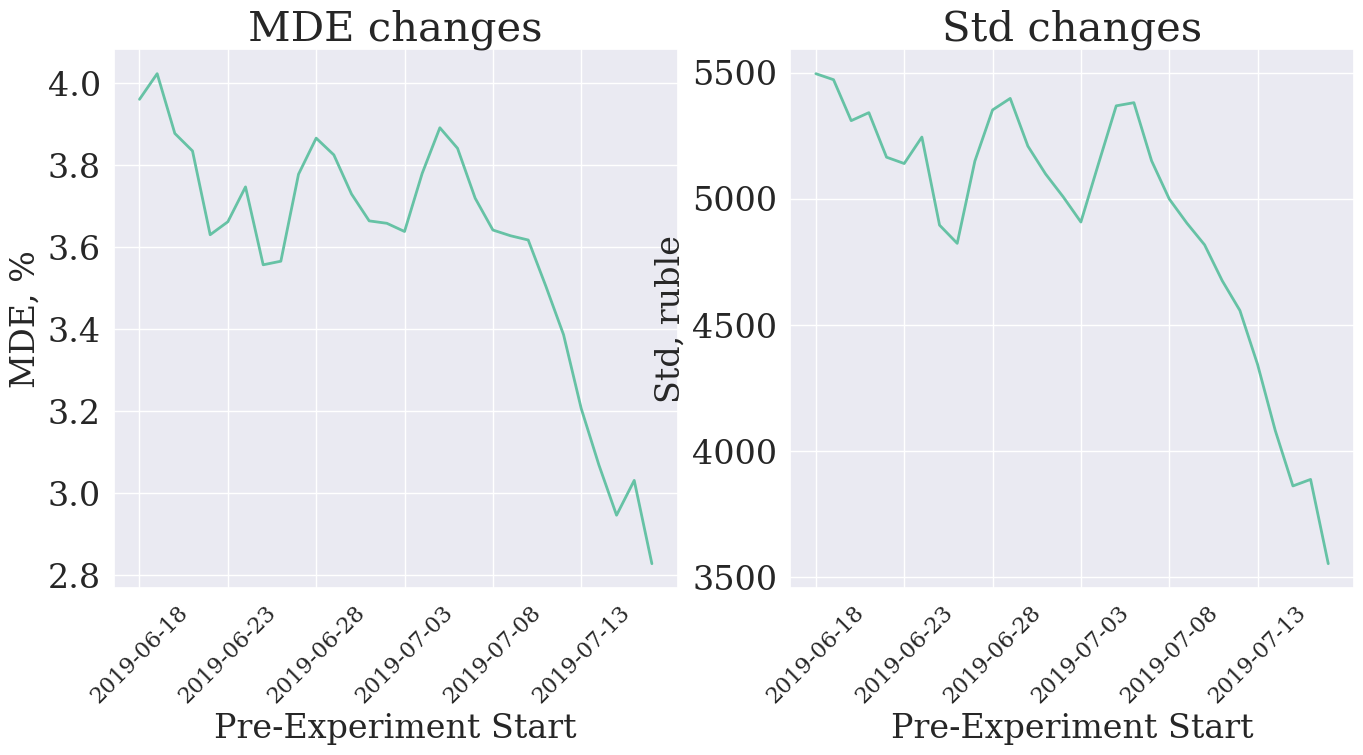

In [244]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].plot(mde_array)
axes[0].set_xticks(range(0, K_DAYS, 5), days_arr[::5], rotation=45)
axes[0].set_xlabel('Pre-Experiment Start')
axes[0].set_ylabel('MDE, %')
axes[0].set_title('MDE changes')

axes[1].plot(std_array)
axes[1].set_xticks(range(0, K_DAYS, 5), days_arr[::5], rotation=45)
axes[1].set_xlabel('Pre-Experiment Start')
axes[1].set_ylabel('Std, ruble')
axes[1].set_title('Std changes')
plt.show()

**Вывод:**  
Сезонность оказывает сильное влияние на MDE: в зависимости от начала предэкспериментального периода MDE варьируется от 2.8% до 4%.  
При этом основное влияние на изменение MDE оказывает изменение стандартного отклонения (среднее и число наблюдении постоянны во времени, уж поверьте на слово)

Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь

In [225]:
exp_days = 30
ratio = 0.5
alpha = 0.01
power = 0.75

max_shift_days = 30
pre_exp_days_arr = (25, 30, 35, 40, 45, 50)
days_arr = []
mde_table = np.zeros((len(pre_exp_days_arr), max_shift_days))

for i, pre_exp_days in enumerate(tqdm(pre_exp_days_arr)):
    for j, k_days_shift in enumerate(range(max_shift_days)):
        # pred_data.user_id % 100 ∈ [0, 2*int(100*ratio))
        # control_data.user_id % 100 ∈ [0, int(100*ratio))
        # test_data.user_id % 100 ∈ [int(100*ratio), 2*int(100*ratio)) because to_shift == True
        
        if k_days_shift + pre_exp_days + exp_days > TOTAL_DAYS:
            continue

        start = df.event_date.min() + pd.to_timedelta(k_days_shift, 'days')
        
        if i == 0:
            days_arr.append(start.date())
        
        # Collect data
        pred_data = choose_date(df, start, pre_exp_days, 2*ratio)
        control_data = choose_date(df, start + pd.to_timedelta(pre_exp_days, 'days'), exp_days, ratio)
        test_data = choose_date(df, start + pd.to_timedelta(pre_exp_days, 'days'), exp_days, ratio, to_shift=True)

        # Filter users: take users only from pred_data
        user_ids_in_exp = set(pred_data['user_id'].values)
        control_data = control_data[control_data.user_id.isin(user_ids_in_exp)]
        test_data = test_data[test_data.user_id.isin(user_ids_in_exp)]

        # Concatenate control and test
        control_data['group'] = 'control'
        test_data['group'] = 'test'
        exp_data = pd.concat((control_data, test_data))

        # control_data.user_id.nunique() + test_data.user_id.nunique() < pred_data.user_id.nunique()
        # Let's fix it!
        user_ids_in_exp = set(control_data['user_id'].values) | set(test_data['user_id'].values)
        pred_data = pred_data[pred_data.user_id.isin(user_ids_in_exp)]
        assert len(pred_data) == len(exp_data)

        # Make user-to-user match between pred_data and exp_data
        # It can be done in two ways: join this tables or sort values by user_id
        # We'll use the second option
        pred_data = pred_data.sort_values(by='user_id', ignore_index=True).reset_index(drop=True)
        exp_data = exp_data.sort_values(by='user_id', ignore_index=True).reset_index(drop=True)

        # Calculate CUPED-metric
        theta = np.cov(pred_data.revenue_amount, exp_data.revenue_amount, ddof=1)[1,0] / np.var(pred_data.revenue_amount, ddof=1)
        corr = np.corrcoef(pred_data.revenue_amount, exp_data.revenue_amount)[1,0] 
        exp_data['cuped_revenue'] = exp_data.revenue_amount - theta * (pred_data.revenue_amount - pred_data.revenue_amount.mean())

        # Calculate MDE
        mde_data = exp_data[exp_data.group == 'control']
        mean = mde_data.cuped_revenue.mean()
        std = mde_data.cuped_revenue.std()

        effect_size = tt_ind_solve_power(None, len(mde_data), alpha, power)
        result_effect = effect_size * std / mean
        
        mde_table[i, j] = result_effect*100

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_41989/1245213800.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


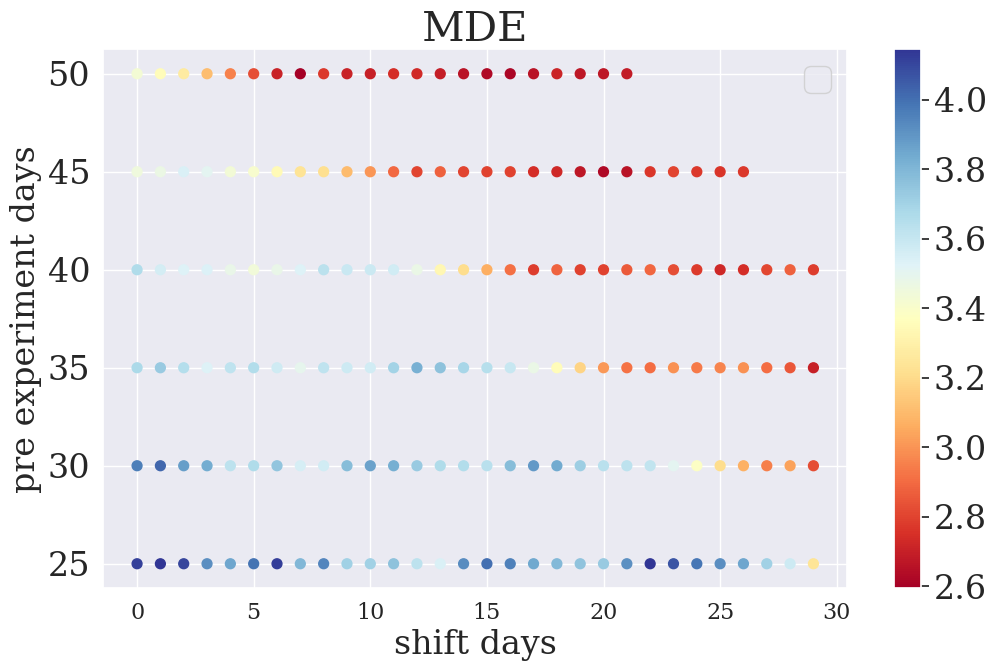

In [234]:
cm = plt.cm.get_cmap('RdYlBu')

nonzero_mde_indices = np.flatnonzero(np.ravel(mde_table))
repeated_shift_days = np.tile(np.arange(max_shift_days), len(pre_exp_days_arr))[nonzero_mde_indices]
repeated_pre_exp_days = np.repeat(pre_exp_days_arr, max_shift_days)[nonzero_mde_indices]
nonzero_mde_arr = np.ravel(mde_table)[nonzero_mde_indices]

sc = plt.scatter(
    x=repeated_shift_days,
    y=repeated_pre_exp_days,
    c=nonzero_mde_arr,
    s=50,
    cmap=cm
)
plt.xlabel('shift days')
plt.ylabel('pre experiment days')
plt.title('MDE')
plt.legend()
plt.colorbar(sc)
plt.show()

In [246]:
argmin_mde = nonzero_mde_arr.argmin()
min_mde = nonzero_mde_arr[argmin_mde]
best_shift_day = repeated_shift_days[argmin_mde]
best_pre_exp_days = repeated_pre_exp_days[argmin_mde]

print(f'Best MDE = {min_mde:.3f}')
print(f'Best Shift = {best_shift_day} days')
print(f'Best PreExperiment Length = {best_pre_exp_days} days')

Best MDE = 2.594
Best Shift = 7 days
Best PreExperiment Length = 50 days


**Вывод:**  
1. Чем длиннее предэкспериментальный период, тем лучше  
2. Понизили MDE с 5.66% до 2.59%  
3. Не стоит забывать про сезональность CUPED-подхода

## Стратификация

In [284]:
def my_choose_data(data: pd.DataFrame, strata_col: str, start_date: Timestamp, delta: int, share: float) -> pd.DataFrame: 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp = tmp.groupby(['user_id', strata_col])['revenue_amount'].sum().reset_index()
    x = tmp[tmp.user_id%100<int(100*share)].reset_index()
        
    return x

In [285]:
days = 30
alpha = 0.01
power = 0.75


for ratio in (0.1, 0.25, 0.5):
    for strata_col in ('user_segment', 'category', 'region'):
        print(f'ratio = {ratio}, strata_col = {strata_col}')

        # Collect data
        pred_data = my_choose_data(df, strata_col, df.event_date.min(), days, ratio)

        # Calculate MDE
        grouped = pred_data.groupby(strata_col)
        weights = grouped[strata_col].count() / len(pred_data)
        
        mean = pred_data.revenue_amount.mean()
        assert abs(mean - sum(grouped.revenue_amount.mean() * weights)) < 1e-4
        var = sum(grouped.revenue_amount.var() * weights)
        std = var**0.5

        effect_size = tt_ind_solve_power(None, len(pred_data), alpha, power)
        result_effect = effect_size * std / mean

        print('k_observations =', len(pred_data))
        print(f'Result effect = {result_effect*100:.3f}%')
        print('='*80)

ratio = 0.1, strata_col = user_segment
k_observations = 64929
Result effect = 10.554%
ratio = 0.1, strata_col = category
k_observations = 70984
Result effect = 10.695%
ratio = 0.1, strata_col = region
k_observations = 65081
Result effect = 9.406%
ratio = 0.25, strata_col = user_segment
k_observations = 162618
Result effect = 8.844%
ratio = 0.25, strata_col = category
k_observations = 177926
Result effect = 8.904%
ratio = 0.25, strata_col = region
k_observations = 162924
Result effect = 5.804%
ratio = 0.5, strata_col = user_segment
k_observations = 325251
Result effect = 5.444%
ratio = 0.5, strata_col = category
k_observations = 355861
Result effect = 5.493%
ratio = 0.5, strata_col = region
k_observations = 325973
Result effect = 3.901%


**Вывод**:  
Сильнее всего уменьшилось MDE со стратификацией по регионам -- до 3.9%. В то время как стратификация по сотальным параметрам лишь незначительно уменьшило MDE (всего на пару десятых процента)  

**Напоминание:**
<u>Было:</u> 11.2%, 9.1%, 5.7% 